# Machine Learning Final
### Kwaku Ofori-Atta
---


## Problem Definition

Online news has gained in popularity -- many many articles hit these services each day and users are faced with the challenge of sifting through  to find conetent that they are interested in. The challenge has thus risen to apply artificial intelligence techniques towards curating articles of interest for users.

### Goal

The Goal of this notebook is to recommend relevant articles to each user based on their past history. I will use MRR, mean reciprocal rank, to measure the relevance of articles recommended. I will employ collaborative filtering, using the browsing history of many different users to predict articles via latent factors that arise in analysis. I will measure success by calculating how many articles recommend fall within a user's interest.

In [ ]:
!pip install pytorch_lightning

In [20]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from collections import defaultdict

## Dataset

This data comes from the [Microsoft News Recommendation Competition](https://github.com/msnews/msnews.github.io/blob/master/assets/doc/introduction.md). This dataset seeks to replicate the challenges of News Recommendation in the wild. New articles are posted continuously, and exisiting articles disappear. There remains the classic cold-start problem where it is difficult to recommend articles to users with no article history.

This dataset has two parts to it.
*   News: Articles, information includes News ID, Category, Subcategory, Title, Abstract, URL, Title Entities (entities contained in the title of this news), Abstract Entities (entities contained in the abstract of this news)
*   Behavior: Browsing history and impressions via clicks, - Impression ID, User ID, Time, History, Impressions.

---

### Biases and Limitations

This Dataset has many users (50,000) and many articles (52,028). A large challenge here is we will have a sparse matrix. Not every user will have read every article and so there will be information a model cannot divine.

Another challenge is that clicks do not always indicate interst in an article, but this is the signal we are basing our model off of.

In [12]:
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

In [13]:
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None

    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [14]:
zip_path = download_url(training_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_train.zip


['entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'behaviors.tsv',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_train.zip',
 'relation_embedding.vec']

In [15]:
# The behaviors.tsv file contains the impression logs and users' news click histories.
# It has 5 columns divided by the tab symbol:
# - Impression ID. The ID of an impression.
# - User ID. The anonymous ID of a user.
# - Time. The impression time with format "MM/DD/YYYY HH:MM:SS AM/PM".
# - History. The news click history (ID list of clicked news) of this user before this impression.
# - Impressions. List of news displayed in this impression and user's click behaviors on them (1 for click and 0 for non-click).
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
behaviors.head()

,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [16]:
# The news.tsv file contains the detailed information of news articles involved in the behaviors.tsv file.
# It has 7 columns, which are divided by the tab symbol:
# - News ID
# - Category
# - Subcategory
# - Title
# - Abstract
# - URL
# - Title Entities (entities contained in the title of this news)
# - Abstract Entities (entities contained in the abstract of this news)
news_path = os.path.join(temp_dir, 'news.tsv')
news = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
news.head()

,id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [17]:
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)

Bypassing download of already-downloaded file MINDsmall_dev.zip


['entity_embedding.vec',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_dev.zip',
 'news.tsv',
 'behaviors.tsv',
 'https_mind201910small.blob.core.windows.net_release_MINDsmall_train.zip',
 'relation_embedding.vec']

In [18]:
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behaviors_val = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

news_path = os.path.join(temp_dir, 'news.tsv')
news_val = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])

## Collaborative Filtering


---

### Model and Assumptions

In this dataset, we have the behaviors -- the article history and information on if they clicked on the article or not. We also information on the article categories. We have about 50k users and about 50k articles.

This makes this dataset a good candidate for Collaborative Filtering. CF-based recommendation systems work by
defining a similarity between people according to their product
preference. Each user is then presented with recommended
items consumed by other users similar to themselves. CF systems utilize information of the products consumed
by users to make their recommendations.

 This can be considered a strength of the approach, as the most pertinent
information for making recommendations is the consumption
of the items from the catalog. However, this can also be
considered a weakness, as a definition of similarity between
users based solely on their consumption of a particular class
of items is very limited.

 Furthermore, this approach makes it
difficult to provide good item recommendations to users who
are new to the system and have made few, if any, purchases
(the so-called ”cold users”). The problem of making recommendations to new users is especially troublesome in many
real-world recommendation systems, where the distribution
of the number of items consumed by each user is heavy. tailed: most people buy few products, and only a few buy
many of them. Similarly, when new items (so-called ”cold
items”) are introduced into the item catalog, it is hard for CF
recommendation systems to recommend these items. Another
shortcoming of CF recommendation systems is that they have
limited capacity to consider temporal changes in user interests,
particularly short-term purchase intent.


MF algorithms are given a description of items and users
as input, typically this description takes the form of a sparse
vector, whose values are either explicit ratings or values
inferred from the user data. The output is a set of vectors,
one for each user and one for each item, spanning a joint useritem latent space. Future user-item interaction can be predicted
based on vector space similarity between the corresponding
vectors. Similarly, the similarity between any pair of catalog
items is approximated by the vector space similarity of the
corresponding pair of vectors.


## Feature Engineering

There were several things I had to do in order to prepare the dataset for modeling

1. Create a ids and lookups for every article and user
2. Create lists of article histories from the tab separated sequences
3. Identify the last item selected in a sequence
4. Remove users with no history or articles with no information
5. Converting the timestamp to hours since the start of the epoch

In [30]:
def create_article_indexes(df, column_name, item2ind):
    """
    Convert the values in a specified column of a DataFrame to index sequences.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to be processed.
        item2ind (dict): A dictionary mapping items to their corresponding indices.

    Returns:
        DataFrame: A copy of the original DataFrame with a new column containing index sequences for the specified column.
    """
    df[column_name + '_idx'] = df[column_name].apply(lambda s: [item2ind.get(l, 0) for l in str(s).split(" ")])
    return df


In [31]:
def process_impressions(df, column_name, item2ind):
    """
    Process impression data in a specified column of a DataFrame using article indexes.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column containing the impression data.
        item2ind (dict): A dictionary mapping items to their corresponding indices.

    Returns:
        DataFrame: A copy of the original DataFrame with new columns 'noclicks_idx' and 'click_idx'.
    """
    # Define a function to process each row of impression data
    def process_impression(s):
        list_of_strings = s.split(" ")
        itemid_rel_tuple = [l.split("-") for l in list_of_strings]
        noclicks = []
        click = None
        for entry in itemid_rel_tuple:
            if entry[1] == '0':
                noclicks.append(item2ind.get(entry[0], 0))  # Use item2ind mapping for no-clicks
            elif entry[1] == '1':
                click = item2ind.get(entry[0], 0)  # Use item2ind mapping for click
        return noclicks, click

    # Apply the process_impression function to each row of the specified column
    df['noclicks_idx'], df['click_idx'] = zip(*df[column_name].map(process_impression))

    return df

In [34]:
from torch.nn.utils.rnn import pad_sequence
class MindDataset(Dataset):
  def __init__(self, df):
    self.data = {
        'user_idx': torch.tensor(df.user_idx.values),
        'click': torch.tensor(df.click_idx.values),
        'noclick': torch.tensor(df.noclicks_idx.values),
        'candidate_list' : pad_sequence([torch.tensor(i, dtype=torch.int64) for i in df.history_idx.to_numpy()], batch_first=True, padding_value=-1)
    }

  def __len__(self):
    return len(self.data['user_idx'])

  def __getitem__(self, idx):
    return {key: val[idx] for key, val in self.data.items()}

In [32]:
users = behaviors['user_id'].unique()
users_val = behaviors_val['user_id'].unique()

ind2user = {idx +1: itemid for idx, itemid in enumerate(np.union1d(users, users_val))}
user2ind = {itemid : idx for idx, itemid in ind2user.items()}

ind2item = {idx +1: itemid for idx, itemid in enumerate(np.union1d(news['id'], news_val['id']))}
item2ind = {itemid : idx for idx, itemid in ind2item.items()}

In [35]:
train = behaviors
train['user_idx'] = train['user_id'].apply(lambda x: np.where(users == x)[0][0])

create_article_indexes(train, 'history', item2ind)
process_impressions(train, 'impressions', item2ind)

train['epochhrs'] = pd.to_datetime(train['time']).values.astype(np.int64)/(1e6)/1000/3600
train['epochhrs'] = train['epochhrs'].round()
train[['click_idx','epochhrs']].groupby("click_idx").min("epochhrs").reset_index()
train['noclicks_idx'] = train['noclicks_idx'].map(lambda x: x[0])
train = train[['epochhrs', 'user_idx', 'history_idx', 'noclicks_idx', 'click_idx']]
train[(train.click_idx!=0) & (train.user_idx != 0)].reset_index(drop=True)

batch = 1024
train_dataset = MindDataset(train)
batch_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
batch = next(iter(batch_loader))

In [36]:
val = behaviors_val
val['user_idx'] = val['user_id'].apply(lambda x: np.where(users_val == x)[0][0])
create_article_indexes(val, 'history', item2ind)
process_impressions(val, 'impressions', item2ind)

val['epochhrs'] = pd.to_datetime(val['time']).values.astype(np.int64)/(1e6)/1000/3600
val['epochhrs'] = val['epochhrs'].round()
val[['click_idx','epochhrs']].groupby("click_idx").min("epochhrs").reset_index()
val['noclicks_idx'] = val['noclicks_idx'].map(lambda x: x[0])
val = val[['epochhrs', 'user_idx', 'history_idx', 'noclicks_idx', 'click_idx']]
val[(val.click_idx!=0) & (val.user_idx != 0)].reset_index(drop=True)

val, holdout = train_test_split(val, test_size=0.2, random_state=42)

batch = 1024
val_dataset = MindDataset(val)
valid_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)

holdout = MindDataset(holdout)

## Dataset Imabalances

- We have more data on no-clicks than clicks
- Article categories are not evenly distributed

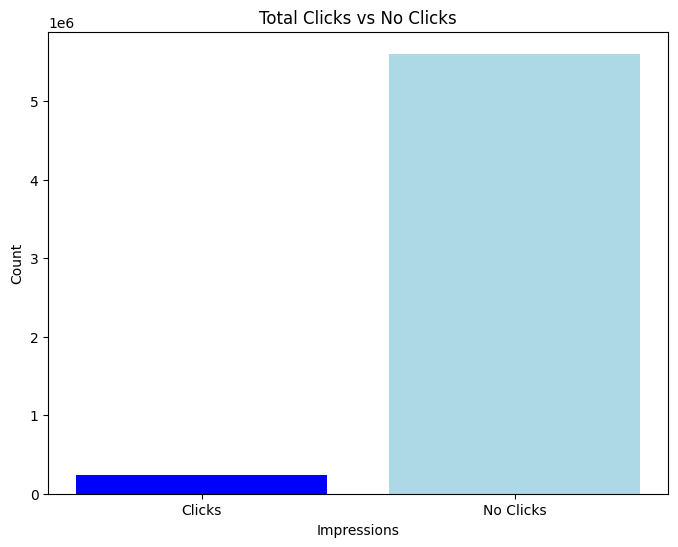

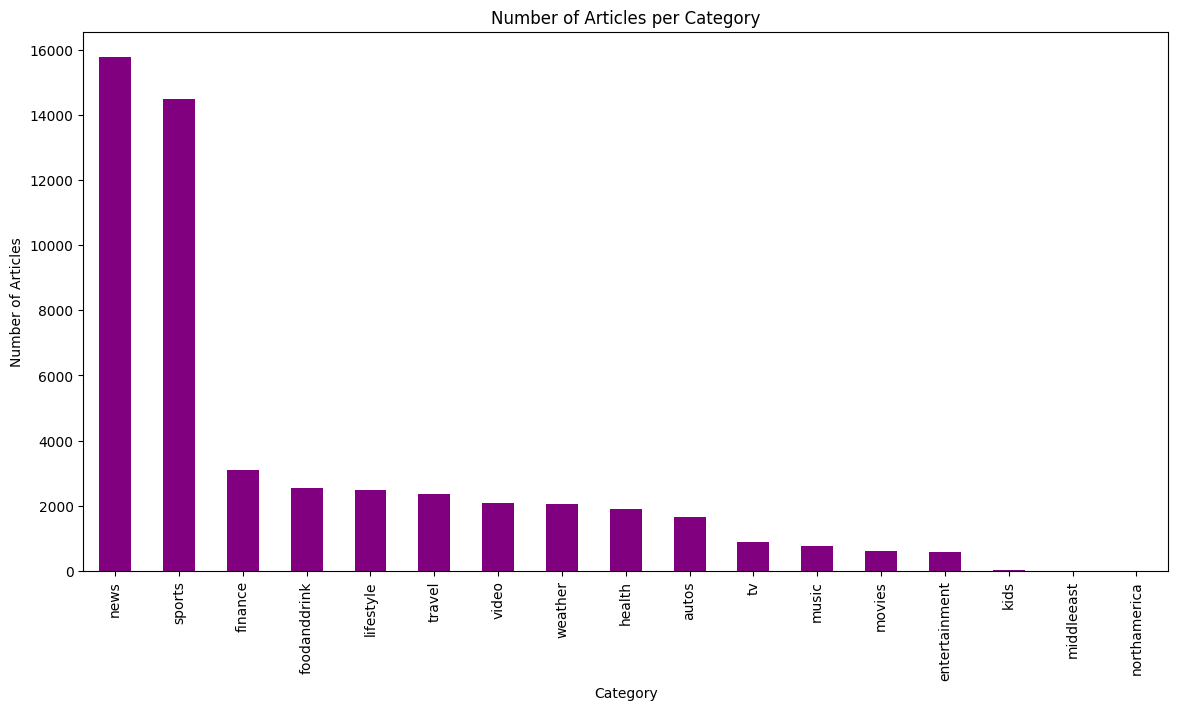

In [47]:
def count_clicks(df, column_name, item2ind):
    """
    Process impression data to count clicks and no-clicks.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column containing the impression data.
        item2ind (dict): A dictionary mapping items to their corresponding indices.

    Returns:
        defaultdict: Counts of no-clicks per article.
        defaultdict: Counts of clicks per article.
    """
    click_counts = defaultdict(int)
    noclick_counts = defaultdict(int)

    for impressions in df[column_name]:
        for impression in impressions.split():
            item_id, label = impression.split('-')
            index = item2ind.get(item_id, 0)
            if label == '0':
                noclick_counts[index] += 1
            elif label == '1':
                click_counts[index] += 1

    return noclick_counts, click_counts

noclick_counts, click_counts = count_clicks(behaviors, 'impressions', item2ind)

total_clicks = sum(click_counts.values())
total_noclicks = sum(noclick_counts.values())

plt.figure(figsize=(8, 6))
categories = ['Clicks', 'No Clicks']
counts = [total_clicks, total_noclicks]

plt.bar(categories, counts, color=['blue', 'lightblue'])
plt.xlabel('Impressions')
plt.ylabel('Count')
plt.title('Total Clicks vs No Clicks')
plt.show()

category_counts = news['category'].value_counts()

plt.figure(figsize=(14, 7))
category_counts.plot(kind='bar', color='purple')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Category')
plt.show()

## Build the Collaborative Filtering Model

## Model Approach

I chose to conduct collaborative filtering via a factorization matrix so that we can understand latent relationship between content sequences and like-users in order to make strong predictions on the dataset.

To handle overfittingand underfitting I conducted the following:

- plotted binary cross entropy loss at every epoch of the model to make sure that the validation set descending at smooth rate

- adjusted the learning rate to prevent jagged loss descent

- added a weight decay parameter, which is the l2 regularizer to ensure better generalizability of the model

- increase the amount of epochs, while plotting MRR over time to ensure the model captures as much information as possible

- plotted MRR to see if there was more infomation to learn and to seet if there was a double-descent

In [ ]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np

class FactorizationMatrix(pl.LightningModule):
    def __init__(self, num_users, num_items, dim=13):
        super().__init__()
        self.dim = dim
        self.userEmbed = nn.Embedding(num_embeddings=num_users, embedding_dim=dim)
        self.itemEmbed = nn.Embedding(num_embeddings=num_items, embedding_dim=dim)

        self.train_losses = []
        self.val_losses = []

        self.predictions = []
        self.true_labels = []
        self.mrr_values = []
        self.auc_values = []

        self.epoch_mrr = []
        self.epoch_auc = []

    def forward(self, user, item):
        userVector = self.userEmbed(user)
        itemVector = self.itemEmbed(item)
        score = (userVector * itemVector).sum(-1)
        return score

    def training_step(self, batch, batch_idx):
        score_click = self.forward(batch['user_idx'], batch['click']).view(-1)
        score_noclick = self.forward(batch['user_idx'], batch['noclick']).view(-1)

        scores_all = torch.cat((score_click, score_noclick), dim=0)
        targets = torch.cat((torch.ones_like(score_click), torch.zeros_like(score_noclick)), dim=0)

        loss = F.binary_cross_entropy_with_logits(scores_all, targets)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        score_click = self.forward(batch['user_idx'], batch['click']).view(-1)
        score_noclick = self.forward(batch['user_idx'], batch['noclick']).view(-1)

        scores_all = torch.cat((score_click, score_noclick), dim=0)
        targets = torch.cat((torch.ones_like(score_click), torch.zeros_like(score_noclick)), dim=0)

        loss = F.binary_cross_entropy_with_logits(scores_all, targets)
        self.val_losses.append(loss.item())

        self.predictions.extend(scores_all.detach().cpu().numpy())
        self.true_labels.extend(targets.detach().cpu().numpy())

        user_ids = batch['user_idx'].cpu().numpy()
        for user_id, click, noclick in zip(user_ids, score_click.unsqueeze(0), score_noclick.unsqueeze(0)):
            scores = torch.cat((click, noclick)).detach().cpu().numpy()
            labels = np.concatenate((np.ones_like(click.cpu().numpy()), np.zeros_like(noclick.cpu().numpy())))
            sorted_indices = np.argsort(-scores)
            rank = np.where(sorted_indices == np.argmax(labels))[0][0] + 1
            self.mrr_values.append(1 / rank)

        return loss

    def on_validation_epoch_end(self):
        auc = roc_auc_score(self.true_labels, self.predictions)
        self.log('val_auc', auc, prog_bar=True)
        self.auc_values.append(auc)

        mrr = np.mean(self.mrr_values)
        self.log('val_mrr', mrr, prog_bar=True)
        self.mrr_values.append(mrr)

        self.predictions.clear()
        self.true_labels.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-1)
        return optimizer

mf_model = FactorizationMatrix(num_users=len(ind2user)+1, num_items=len(ind2item)+1)


In [ ]:
logger = TensorBoardLogger("logger", name="FactorizationMatrix")
trainer = pl.Trainer(max_epochs=100 ,accelerator="gpu", logger=logger)
trainer.fit(model=mf_model, train_dataloaders=batch_loader, val_dataloaders=valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type      | Params
----------------------------------------
0 | userEmbed | Embedding | 1.2 M 
1 | itemEmbed | Embedding | 848 K 
----------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.283     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


## Model Justificaition

The collaborative filtering model had about 2.1 million parameters (1.2M from the user embedding fed into the factorization matrix and 848k from the item embedding).

-  I used Adam as the optimization algorithm.

- I used a GPU to train the model and had to drop the learning rate to 0.0001, and applied an l2 parameter of 0.1.

- I also trained with a batch size of 1024 and pumped the latent factors from an initial 10 to 13.

- I trained the model for 100 epochs.

I found that these decisions balanced a smooth learning rate (no overfitting) with maximizing our accuracy parameter, MRR (no underfitting) to deliver our results.

Vvalidation curve has a smooth descent indicating that we do not have overfitting

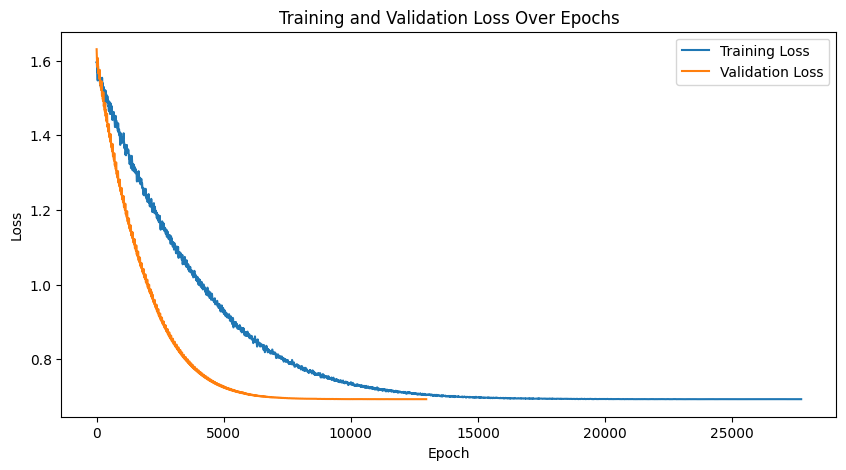

In [ ]:
train_losses = mf_model.train_losses
val_losses = mf_model.val_losses

sigma = 5
train_losses_smooth = gaussian_filter1d(train_losses, sigma=sigma)
val_losses_smooth = gaussian_filter1d(val_losses, sigma=sigma)

plt.figure(figsize=(10, 5))
plt.plot(train_losses_smooth, label='Training Loss')
plt.plot(val_losses_smooth, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

MRR performance tops out at 0.25

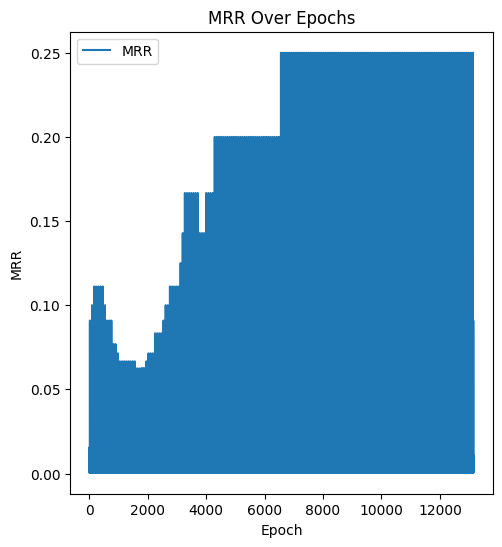

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mf_model.mrr_values, label='MRR')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.title('MRR Over Epochs')
plt.legend()

In [ ]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def compare_categories(user_id, behaviors, news, mf_model, ind2item):
    user_history_str = behaviors[behaviors['user_idx'] == user_id]['history'].values[0]
    user_history_ids = user_history_str.split('\t')[0].split()

    user_history_categories = news[news['id'].isin(user_history_ids)]['category']
    history_category_counts = Counter(user_history_categories)

    history_category_df = pd.DataFrame.from_dict(history_category_counts, orient='index').reset_index()
    history_category_df.columns = ['category', 'count']
    history_category_df = history_category_df.sort_values(by='count', ascending=False)

    item_id = list(ind2item.keys())
    userIdx =  [user_id]*len(item_id)
    predictions = mf_model.forward(torch.IntTensor(userIdx), item=torch.IntTensor(item_id))
    top_index = torch.topk(predictions.flatten(), 10).indices
    filters = [ind2item[ix.item()] for ix in top_index]

    predicted_categories = news[news['id'].isin(filters)]['category']
    predicted_category_counts = Counter(predicted_categories)

    predicted_category_df = pd.DataFrame.from_dict(predicted_category_counts, orient='index').reset_index()
    predicted_category_df.columns = ['category', 'count']
    predicted_category_df = predicted_category_df.sort_values(by='count', ascending=False)

    history_category_df['type'] = 'history'
    predicted_category_df['type'] = 'predicted'

    combined_df = pd.concat([history_category_df, predicted_category_df])

    plt.figure(figsize=(12, 6))
    sns.barplot(data=combined_df, x='category', y='count', hue='type', dodge=True)
    plt.xticks(rotation=45)
    plt.title(f'Comparison of News Categories for User {user_id}')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.legend(title='Type', loc='upper right')
    plt.show()

## Results and Insights

### MRR

I used MRR - the average of reciprocal rank (RR) over users as the performance accuracy metric. MRR allows us to evaluate the performance of recommender systems and is one of the standard benchmarks of the MIND dataset.

For each query, I find the rank of the first relevant result in the ranked list, take the inverse of the rank, and calculate the average rank across of all the queries.

MRR = (1/|Q|) * Σ (1/rank_i)

MRR (Mean Reciprocal Rank) is a metric used to evaluate the performance of ranking systems, such as search engines, recommender systems, or machine translation models. It measures how well the system ranks the relevant items or correct answers at the top of the result list.
How MRR is Calculated
MRR is calculated as follows:
For each query, find the rank of the first correct/relevant result in the ranked list.

A rank of 1 would mean that, on average, the first rank would be relevant. An MRR of 1/10 would mean that, on average the tenth rank would be most relevant. **Our MRR topped out at 1/4 (0.25)** meaning that on average the 4th article recommended was the most relevant.

MRR is well-suited for scenarios where only the first relevant result is important. One drawback is that additional relevant results are not considered.

### Looking At The Users

Below we took a look at indivdual users and how the recommendation model performed. On the graph the blue bars represent a user's history. The orange bars represent the categories of the first 10 predictions generated by the recommender.

I both spot checked an average user and I also pulled the 3 users with the longest histories and analyzed their results.

Two general takeaways of the model are the following...

  1. the recommender will get you recommendations in your top 2 categories
  
  2. the article distribution is imbalanced. in general, the data has more examples of sports, and finance articles than music and movie articles nad so those articles get recommended more even when less representative in an idividual's history. Chances are if you look at a sports article, you'll be recommended a sports article

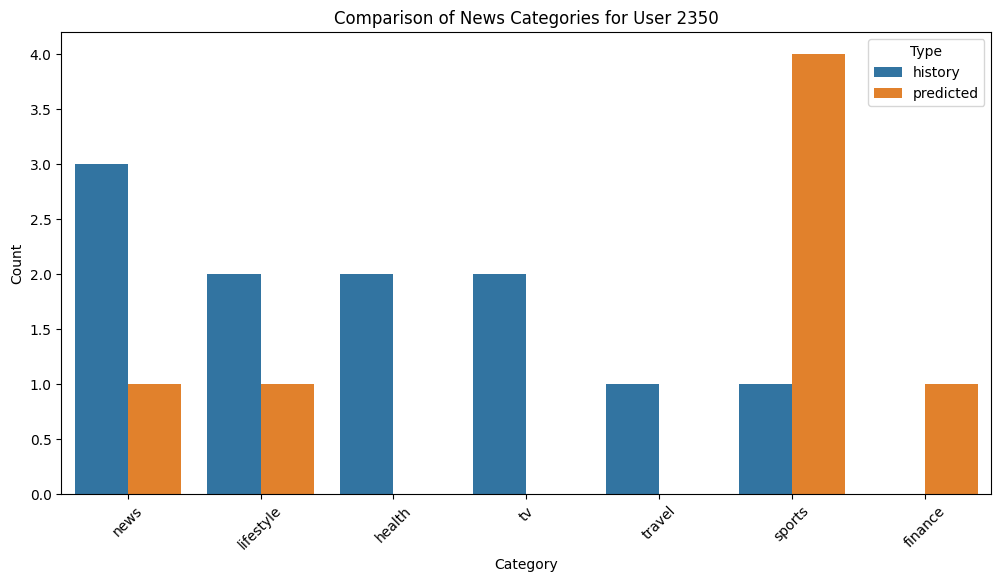

In [ ]:
USER_ID = 2350
compare_categories(USER_ID, behaviors, news, mf_model, ind2item)

In [ ]:
holdout['history_length'] = holdout['history'].apply(lambda x: len(set(x.split())) if isinstance(x, str) else 0)
users_sorted_by_history_length = holdout.sort_values(by='history_length', ascending=False)

# Get the top 3 users with the longest histories
top_users = users_sorted_by_history_length.head(100)['user_idx'].unique()
top_users

array([ 1212,  6220,  6157, 12975,  5190])

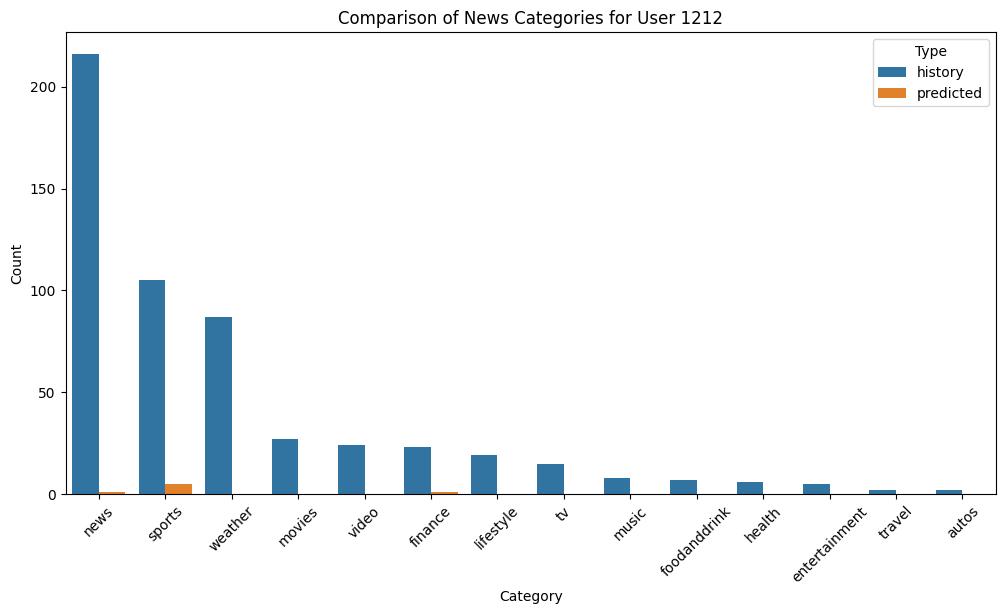

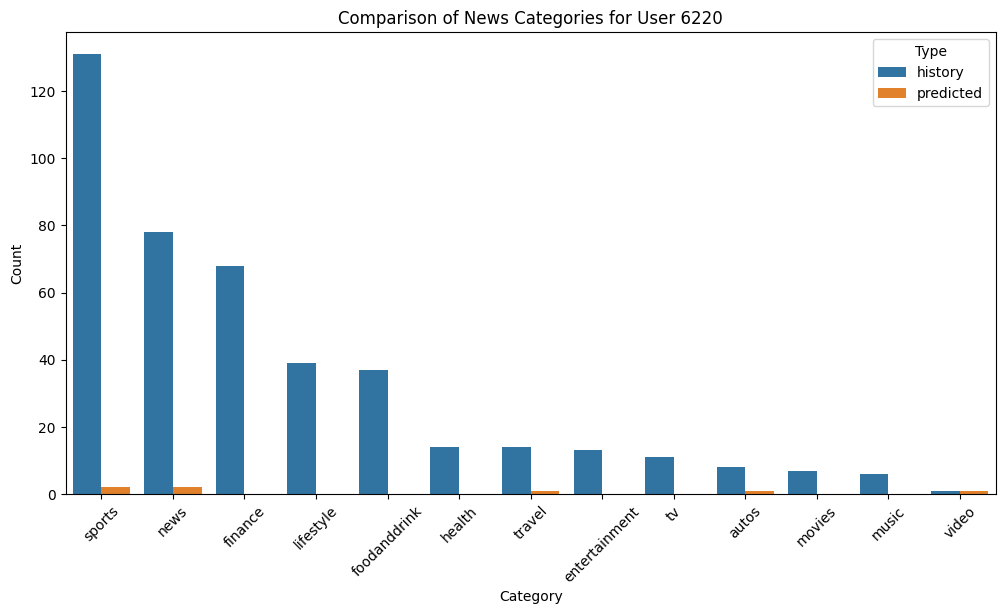

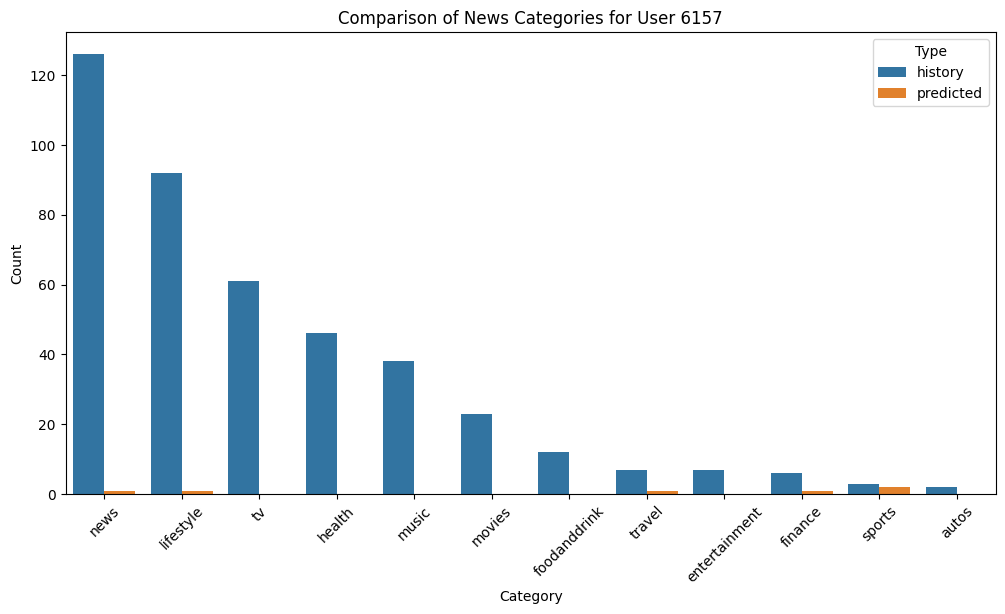

In [ ]:
for user_id in top_users[0:3]:
  compare_categories(user_id, holdout, news, mf_model, ind2item)

In [ ]:
from ast import Num

def recall_k(click, impression, k=50):
  click = click.clone().detach()
  impression = impression.clone().detach()
  is_in_top_k = torch.isin(impression[0:k], click).sum()
  recall = is_in_top_k.float() / len(click)
  return recall

class FactorizationMatrixRecall(pl.LightningModule):
  def __init__(self, num_users, num_items, dim=10):
    super().__init__()
    self.dim=dim
    self.num_users = num_users
    self.num_items = num_items

    self.userEmbed = nn.Embedding(num_embeddings=num_users, embedding_dim=dim)
    self.itemEmbed = nn.Embedding(num_embeddings=num_items, embedding_dim=dim)

  def forward(self, user, item):
    userVector = self.userEmbed(user)
    itemVector = self.itemEmbed(item)

    dot_product = (userVector * itemVector).sum(-1).unsqueeze(-1)
    score = torch.sigmoid(dot_product)
    return score

  def step(self, batch, batch_idx, phase="train"):
    batch_size = batch['user_idx'].size(0)
    uservec = self.userEmbed(batch['user_idx'])
    itemvec_click = self.itemEmbed(batch['click'])

    neg_sample = torch.randint_like(batch["click"],1,self.num_items)
    itemvec_noclick = self.itemEmbed(neg_sample)

    score_click = torch.sigmoid((uservec*itemvec_click).sum(-1).unsqueeze(-1))
    score_noclick =  torch.sigmoid((uservec*itemvec_noclick).sum(-1).unsqueeze(-1))

    scores_all = torch.concat((score_click, score_noclick), dim=1)
    target_all = torch.concat((torch.ones_like(score_click), torch.zeros_like(score_noclick)),dim=1)
    loss = F.binary_cross_entropy(scores_all, target_all)

  def training_step(self, batch, batch_idx):
    batch_size = batch['user_idx'].size(0)
    batch_user = batch['user_idx']
    batch_click = batch['click']

    score_click = self.forward(batch['user_idx'], batch['click'])
    score_noclick = self.forward(batch['user_idx'], batch['noclick'])

    scores_all = torch.concat((score_click, score_noclick), dim=1)
    target_all = torch.concat((torch.ones_like(score_click), torch.zeros_like(score_noclick)),dim=1)

    loss = F.binary_cross_entropy(scores_all, target_all)
    self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    return loss


  def validation_step(self, batch, batch_idx):
    loss = self.training_step(batch, batch_idx)
    self.log('Loss: ', loss, prog_bar=True, on_step=False, on_epoch=True)
    self.val_losses.append(loss.item())
    return loss

  # def validation_step(self, batch, batch_idx):
  #   # for now, just do the same computation as during training
  #   batch_size = batch['user_idx'].size(0)
  #   batch_user = batch['user_idx']
  #   batch_click = batch['click']

  #   neg_sample = torch.randint_like(batch_click,1,self.num_items)

  #   score_click = self.forward(batch_user, batch_click)
  #   score_noclick =  self.forward(batch_user, neg_sample)

  #   # Compute loss as binary cross entropy (categorical distribution between the clicked and the no clicked item)
  #   scores_all = torch.concat((score_click, score_noclick), dim=1)
  #   target_all = torch.concat((torch.ones_like(score_click), torch.zeros_like(score_noclick)),dim=1)
  #   val_loss = F.binary_cross_entropy(scores_all, target_all)
  #   self.log("validation_loss", val_loss, prog_bar=True, on_step=False, on_epoch=True)

  #   recall = torch.zeros(batch_size)
  #   for i, (user,click,candidate) in enumerate(zip(batch['user_idx'], batch["click"], batch["candidate_list"])):
  #       click = click.masked_select(click != -1)
  #       candidate = candidate.masked_select(candidate != -1)
  #       sorting = self.forward(user,candidate).argsort(0,descending=True)
  #       candidate_sorted = candidate[sorting]
  #       recall[i] = recall_k(click,candidate_sorted, k=3)

  #   self.log("validation_recall", torch.mean(recall), prog_bar=True, on_step=False, on_epoch=True)
  #   return {'validation_loss':val_loss, 'validation_recall':torch.mean(recall)}

  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
      return optimizer

recall_model = FactorizationMatrixRecall(len(ind2user)+1, len(ind2item)+1)

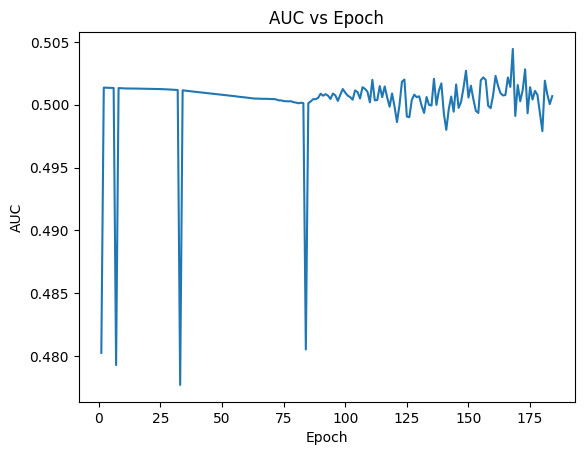

In [ ]:
plt.plot(range(1, len(mf_model.auc_values) +1), mf_model.auc_values)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC vs Epoch')
plt.grid(False)
plt.show()

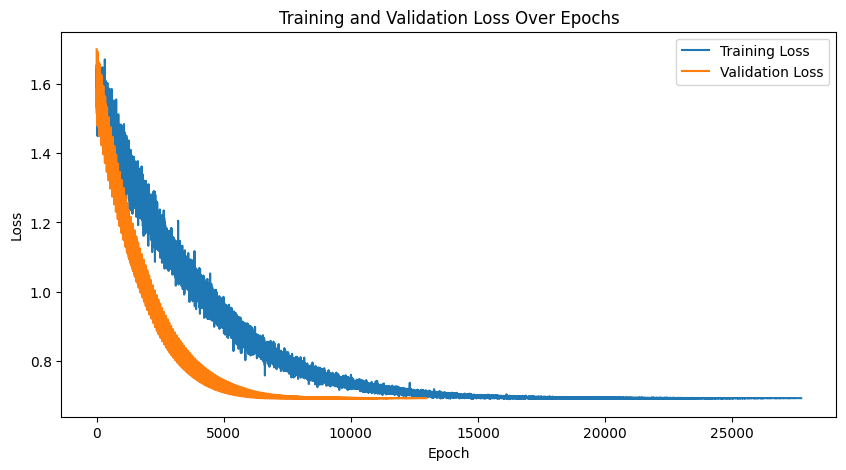

In [ ]:
import matplotlib.pyplot as plt

train_losses = mf_model.train_losses
val_losses = mf_model.val_losses

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

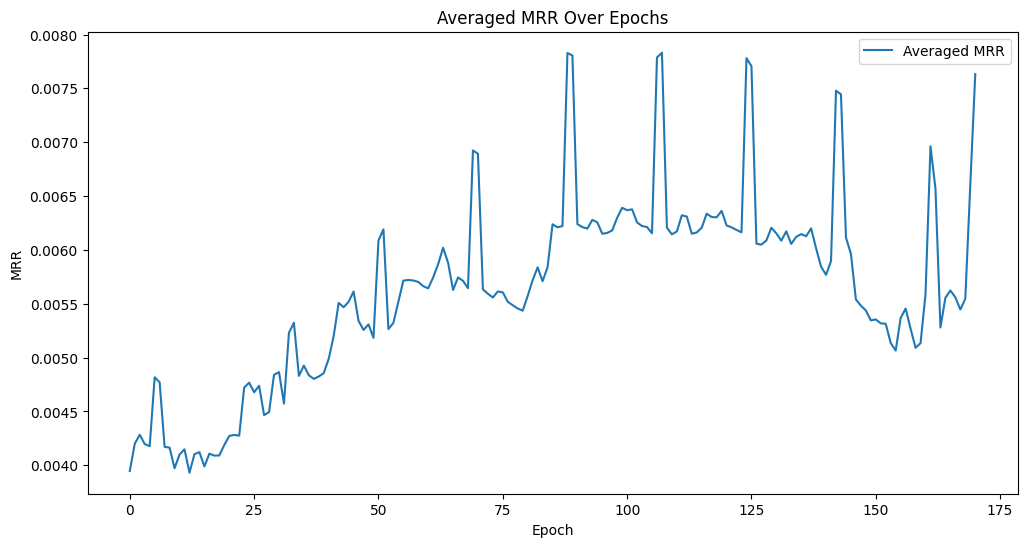

In [ ]:
mrr_values = mf_model.mrr_values

averaged_mrr_values = [np.mean(mrr_values[i:i+len(batch_loader)]) for i in range(0, len(mrr_values), int(len(batch_loader)/2))]

plt.figure(figsize=(12, 6))

# Plot averaged MRR
plt.plot(averaged_mrr_values, label='Averaged MRR')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.title('Averaged MRR Over Epochs')
plt.legend()
plt.show()